In [12]:
%reload_ext autoreload
%load_ext dotenv 
%dotenv -o -v .env

from DbConnexion import DbConnexion



Db = DbConnexion(required_privileges={'SELECT'})

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
--- vérification de la BDD ---
ping...
ping réussi
vérification des permissions...
Récupération des privilèges de l'utilisateur...
vérification des permissions réussie
Vérification des tables...
La table history_change existe
La table station_information existe
La table station_status existe


In [2]:
import folium
import mysql.connector
from mysql.connector import errorcode
from colors import Fore, Style
from cursorContext import cursorContext
import pandas as pd


query = """
SELECT i.stationcode, i.name, i.capacity, ST_X(coordonnees_geo) AS lon, ST_Y(coordonnees_geo) AS lat, 
i.nom_arrondissement_communes, s.date, s.is_installed, s.numdocksavailable, s.numbikesavailable, s.mechanical, s.ebike
    FROM station_information i 
    INNER JOIN station_status s ON s.stationcode = i.stationcode 
    WHERE s.date = ( 
      SELECT MAX(date) 
      FROM station_status 
      WHERE stationcode = i.stationcode 
    )
"""
stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

data = pd.DataFrame(stations, columns=cursor.column_names)
display(data.head())

NameError: name 'Db' is not defined

In [ ]:
from folium.features import DivIcon

def generate_icon(perc, text, color):
    return DivIcon(
        html=f"""
        <svg width="50px" height="50px" viewBox="0 0 42 42" className="donut" aria-labelledby="beers-title beers-desc" role="img">
                <circle className="donut-hole" cx="21" cy="21" r="15.91549430918954" fill="white" role="presentation"></circle>
                <circle className="donut-ring" cx="21" cy="21" r="15.91549430918954" fill="transparent" stroke="#d2d3d4" strokeWidth="3" role="presentation"></circle>
                <circle className="donut-segment" cx="21" cy="21" r="15.91549430918954" fill="transparent" stroke="{color}" strokeWidth="3" strokeDasharray="{perc} {100 - perc}" strokeDashoffset="25" aria-labelledby="donut-segment-1-title donut-segment-1-desc">
                </circle>
                <g className="chart-text">
                    <text className="chart-number" x="50%" y="52%" dominantBaseline="middle" textAnchor="middle">
                        {text}
                    </text>
                </g>
            </svg>
        """,
        icon_size=(50, 50),
        popup_anchor=(0, -30)
    )

In [ ]:
import folium
from folium.plugins import MarkerCluster

print(len(data))

# filtrer donnée seulement paris
filter_data = data.loc[data['nom_arrondissement_communes'].str.lower() == 'paris']


m = folium.Map(location=[48.856, 2.352], zoom_start=12)
	
marker_cluster = MarkerCluster().add_to(m)


for index, row in filter_data.iterrows():
    pourc = round((row['numbikesavailable'] / row['capacity']) * 100) if row['capacity'] > 0 else 0;
    folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=generate_icon(perc=pourc, text=row['numbikesavailable'], color="hsl(130, 100%, 40%)")).add_to(marker_cluster)

m

In [5]:
from mysql.connector import errorcode
from colors import Fore, Style
from cursorContext import cursorContext
import pandas as pd

query = """
WITH cte_station_status_22h AS (
    SELECT
        ss.stationcode,
        si.name,
        si.coordonnees_geo,
        AVG(ss.numbikesavailable / si.capacity) AS remplissage_moyen
    FROM
        station_status AS ss
    INNER JOIN
        station_information AS si ON ss.stationcode = si.stationcode
    WHERE
        HOUR(ss.date) = 22 AND si.capacity > 0
    GROUP BY
         si.stationcode, si.name
),
cte_station_vide AS (
    SELECT stationcode, name, remplissage_moyen, coordonnees_geo
    FROM cte_station_status_22h
    WHERE remplissage_moyen < 0.1
),
cte_station_proche AS (
    SELECT
        stv.stationcode,
        stv.name,
        stv.remplissage_moyen,
        sp.stationcode AS station_pleine,
        sp.name AS station_pleine_name,
        sp.remplissage_moyen AS remplissage_station_pleine,
        ST_Distance_Sphere(stv.coordonnees_geo, sp.coordonnees_geo) AS distance,
        ROW_NUMBER() OVER (PARTITION BY stv.stationcode, stv.name ORDER BY ST_Distance_Sphere(stv.coordonnees_geo, sp.coordonnees_geo)) AS row_num    FROM
        cte_station_vide AS stv
    LEFT JOIN cte_station_status_22h AS sp ON sp.remplissage_moyen >= 0.8
)
SELECT
    stationcode,
    name,
    remplissage_moyen,
    station_pleine,
    station_pleine_name,
    remplissage_station_pleine,
    distance
FROM
    cte_station_proche
WHERE
    row_num = 1;
"""

stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

data = pd.DataFrame(stations, columns=cursor.column_names)
display(data)

,stationcode,name,remplissage_moyen,station_pleine,station_pleine_name,remplissage_station_pleine,distance
0,10023,Gare de l'Est - Verdun,0.06382021,11003,Keller - La Roquette,0.83370798,2520.580329
1,10033,Gare du Nord - Saint-Vincent de Paul,0.09929255,11003,Keller - La Roquette,0.83370798,3282.174667
2,10107,Gare du Nord - Hôpital Lariboisière,0.09513032,11003,Keller - La Roquette,0.83370798,3381.008817
3,11014,Place de la Nation - Taillebourg,0.01426729,12027,Montgallet - Charenton,0.84375000,1067.078385
4,12164,Stade Pershing,0E-8,43402,Place de Verdun,0.84022606,1495.857859
...,...,...,...,...,...,...,...
71,9022,Rossini - Laffitte,0.08558457,11003,Keller - La Roquette,0.83370798,3370.263630
72,9023,Laffitte - Italiens,0.09678910,11003,Keller - La Roquette,0.83370798,3320.942114
73,9035,Gare Saint-Lazare - Place de Budapest,0.08801144,15025,Dupleix - du Guesclin,0.81653590,3681.723069
74,9102,Londres - Place d'Estienne d'Orves,0.09287234,15025,Dupleix - du Guesclin,0.81653590,3739.462461


In [10]:
from tableDefinition import TABLES, build_table_query, log_table

for table in TABLES:
    print(build_table_query(table.name, table.columns, table.foreign_keys, table.bonuses))


print(build_table_query(log_table["name"], log_table["columns"]))


CREATE TABLE station_information (stationcode VARCHAR(20) NOT NULL PRIMARY KEY, name VARCHAR(255) NOT NULL, capacity INT NOT NULL, coordonnees_geo POINT NOT NULL, nom_arrondissement_communes VARCHAR(255) NOT NULL);
CREATE TABLE station_status (date DATETIME NOT NULL, stationcode VARCHAR(20) NOT NULL, is_installed VARCHAR(3) NOT NULL, numdocksavailable INT NOT NULL, numbikesavailable INT NOT NULL, mechanical INT NOT NULL, ebike INT NOT NULL, CONSTRAINT `fk_stationcode` FOREIGN KEY (stationcode) REFERENCES station_information (stationcode) ON DELETE CASCADE ON UPDATE CASCADE, PRIMARY KEY (stationcode, date));
CREATE TABLE history_change (DATE DATETIME NOT NULL, USER VARCHAR(50) NOT NULL, TYPE VARCHAR(50) NOT NULL, TABLE_AFFECTED VARCHAR(50) NOT NULL, MSG VARCHAR(255) NOT NULL);


In [104]:
# WHERE date >= '2023-05-27 00:00:00' AND date <= '2023-06-04 23:59:59'
query = "SELECT st.date, SUM(st.numbikesavailable) as sumbikesavailable, SUM(st.numdocksavailable) as sumdocksavailable, SUM(st.ebike) as sumebike, SUM(st.mechanical) as summechanical  FROM station_status st GROUP BY date;"

stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

data = pd.DataFrame(stations, columns=cursor.column_names)
display(data)

# date | sumbikesavailable | sumdocksavailable | sumebike | summechanical


,date,sumbikesavailable,sumdocksavailable,sumebike,summechanical
0,2023-04-17 14:35:04,14898,29032,5404,9494
1,2023-04-17 14:40:03,14868,29066,5380,9488
2,2023-04-17 14:45:04,14771,29163,5322,9449
3,2023-04-17 14:50:03,14697,29234,5270,9427
4,2023-04-17 14:55:04,14662,29265,5264,9398
...,...,...,...,...,...
8657,2023-06-04 00:45:02,16107,27541,6063,10044
8658,2023-06-04 00:50:03,16182,27462,6121,10061
8659,2023-06-04 00:55:02,16276,27374,6168,10108
8660,2023-06-04 01:00:04,16372,27271,6222,10150


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


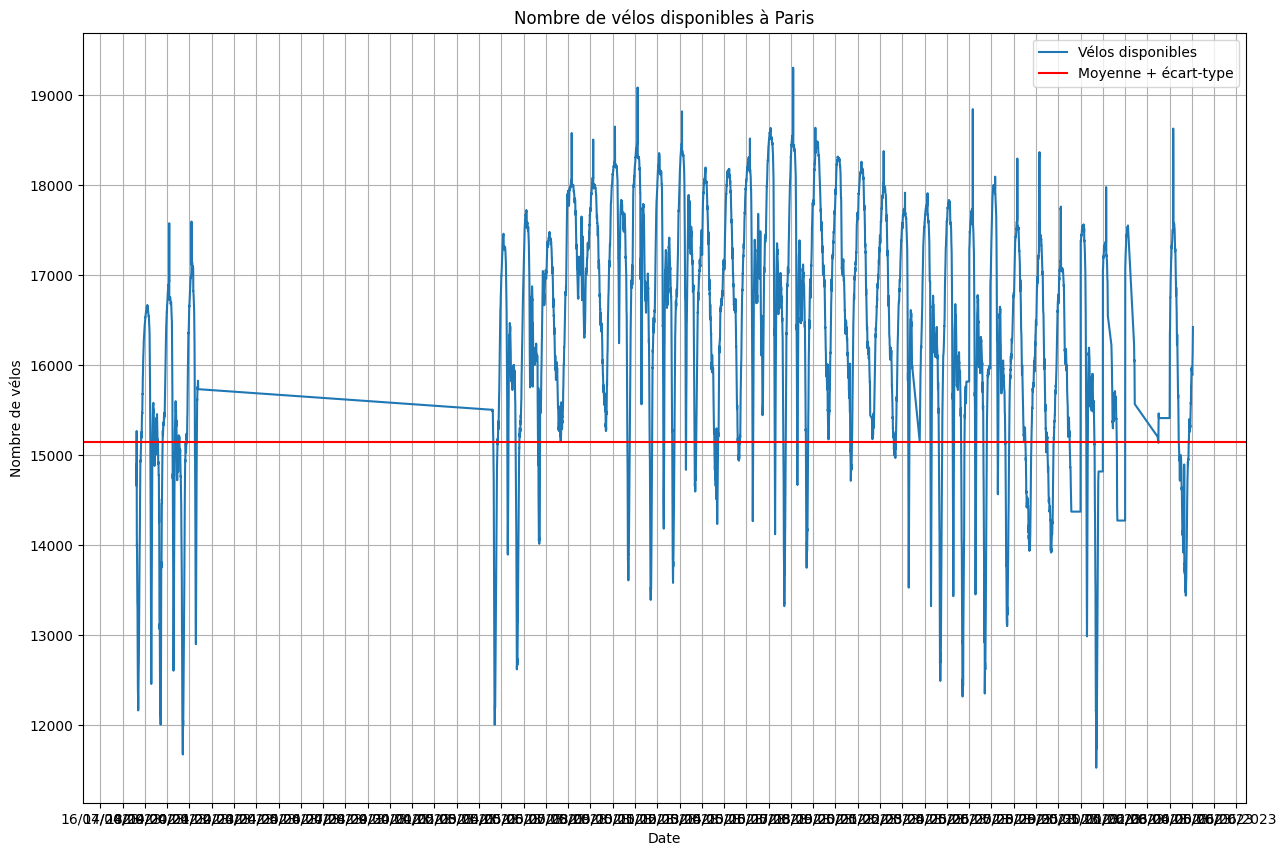

hour
16    295
17    265
18    208
15    190
7      92
19     91
14     88
6      86
13     63
20     54
12     39
23     36
21     36
22     36
11     33
10     26
5       5
8       4
0       3
Name: count, dtype: int64
19305.0


C:\Users\Maxpi\AppData\Local\Temp\ipykernel_33572\269428427.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['date'].apply(lambda x: x.hour)


In [108]:
%pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

fig, ax = plt.subplots(figsize=(15, 10))

data['sumbikesavailable'] = data['sumbikesavailable'].apply(lambda x: float(x))
data['sumdocksavailable'] = data['sumdocksavailable'].apply(lambda x: float(x))
data['sumebike'] = data['sumebike'].apply(lambda x: float(x))
data['summechanical'] = data['summechanical'].apply(lambda x: float(x))

ax.plot(data['date'], data['sumbikesavailable'], label="Vélos disponibles")

mean = data['sumbikesavailable'].median()
std = data['sumbikesavailable'].std()

# set bar at std for sumbikesavailable
ax.axhline(y=(mean - std), color='r', linestyle='-', label="Moyenne + écart-type")

ax.set(xlabel='Date', ylabel='Nombre de vélos',
         title='Nombre de vélos disponibles à Paris')
ax.grid()

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.legend()
plt.show()

# trouver toutes les dates où le nombre de vélos disponibles est supérieur à la moyenne + écart-type
filtered_data = data[data['sumbikesavailable'] < (mean - std)]

# count most frequent hour
filtered_data['hour'] = filtered_data['date'].apply(lambda x: x.hour)
values = filtered_data['hour'].value_counts()

print(values)
print(data['sumbikesavailable'].max())




In [34]:
query = """
SELECT
    stationcode,
    SUM(total_movement) AS total_movement,
    nom_arrondissement_communes
FROM
    (
    SELECT
        si.stationcode,
        ABS(COALESCE(ss.numbikesavailable - LAG(ss.numbikesavailable) OVER (PARTITION BY ss.stationcode ORDER BY ss.date), 0)) AS total_movement,
        si.nom_arrondissement_communes AS nom_arrondissement_communes
    FROM
        station_information AS si
        INNER JOIN station_status AS ss ON si.stationcode = ss.stationcode
    WHERE
        si.capacity > 0
    ) AS subquery
GROUP BY
    stationcode;
"""

stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

data = pd.DataFrame(stations, columns=cursor.column_names)
display(data)

,stationcode,total_movement,nom_arrondissement_communes
0,10001,5641,Paris
1,10003,4768,Paris
2,10004,7691,Paris
3,10005,5049,Paris
4,10006,8288,Paris
...,...,...,...
1444,92004,1025,Nanterre
1445,92005,1362,Nanterre
1446,92006,901,Nanterre
1447,92007,1622,Nanterre


In [39]:
# data colonnes : stationcode, total_movement et nom_arrondissement_communes

# regrouper le mouvement total par commune et faire la somme
data2 = data.groupby(['nom_arrondissement_communes'])[["total_movement"]].sum()

# afficher le résultat trié par ordre décroissant
data2.sort_values(by=['total_movement'], ascending=False, inplace=True)

sum_movement = data2['total_movement'].sum()
data2['percentage'] = data2['total_movement'].apply(lambda x: round((x / sum_movement) * 100))
display(data2)

,total_movement,percentage
nom_arrondissement_communes,,
Paris,4031114,78
Boulogne-Billancourt,103187,2
Montreuil,75371,1
Pantin,58801,1
Ivry-sur-Seine,58077,1
...,...,...
Argenteuil,2171,0
Choisy-le-Roi,2119,0
Chaville,2072,0


In [62]:
query = """
SELECT
    si.*,
    COALESCE(
        (SELECT AVG(numbikesavailable / capacity) FROM station_status WHERE stationcode = si.stationcode),
        -1
    ) AS remplissage_moyen,
    COALESCE(
        (SELECT AVG(numdocksavailable) FROM station_status WHERE stationcode = si.stationcode),
        -1
    ) AS docks_disponibles,
    COALESCE(
        (SELECT AVG(numbikesavailable) FROM station_status WHERE stationcode = si.stationcode),
        -1
    ) AS velos_disponibles,
    COALESCE(
        (SELECT AVG(mechanical) FROM station_status WHERE stationcode = si.stationcode),
        -1
    ) AS velos_mecaniques_disponibles,
    COALESCE(
        (SELECT AVG(ebike) FROM station_status WHERE stationcode = si.stationcode),
        -1
    ) AS velos_electriques_disponibles
FROM
    station_information AS si
WHERE
    si.capacity > 0
"""

stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

data = pd.DataFrame(stations, columns=cursor.column_names)
display(data)

,stationcode,name,capacity,coordonnees_geo,nom_arrondissement_communes,remplissage_moyen,docks_disponibles,velos_disponibles,velos_mecaniques_disponibles,velos_electriques_disponibles
0,10001,René Boulanger - Lancry,62,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 141, 164, 147, 91,...",Paris,0.19260050,48.5693,11.9412,8.5308,3.4105
1,10003,Hauteville - Bonne Nouvelle,17,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 172, 9, 218, 27, 2...",Paris,0.32055496,10.5951,5.4494,2.7437,2.7057
2,10004,Metz - Faubourg Saint-Denis,48,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 254, 151, 107, 209...",Paris,0.38353825,27.0979,18.4098,13.8189,4.5910
3,10005,Petites Ecuries - Faubourg Poissonnière,17,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 122, 55, 126, 11, ...",Paris,0.44411018,8.5566,7.5499,4.9377,2.6122
4,10006,Petites Ecuries - Faubourg Saint-Denis,29,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 184, 110,...",Paris,0.37412320,16.4791,10.8496,7.4449,3.4046
...,...,...,...,...,...,...,...,...,...,...
1444,92004,Nanterre - Université,20,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 124, 180, 56, 99, ...",Nanterre,0.30697876,12.9310,6.1396,3.0441,3.0955
1445,92005,Gare de Nanterre Ville,43,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 198, 59, 118, 6, 2...",Nanterre,0.19329549,33.5946,8.3117,4.5987,3.7130
1446,92006,Place Nelson Mandela,30,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 172, 10, ...",Nanterre,0.13050489,25.7446,3.9151,0.9894,2.9258
1447,92007,Pesaro - Préfecture,22,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 117, 144,...",Nanterre,0.22667450,16.4731,4.9868,1.8102,3.1766


In [63]:
# data colonnes : 	stationcode	name	capacity	coordonnees_geo	nom_arrondissement_communes	remplissage_moyen	docks_disponibles	velos_disponibles	velos_mecaniques_disponibles	velos_electriques_disponibles
data2 = data.copy(deep=True)

# convertir décimal en float
data2['remplissage_moyen'] = data2['remplissage_moyen'].apply(lambda x: float(x))


q3 = data2['remplissage_moyen'].quantile(0.75)

data2 = data2[data2['remplissage_moyen'] > q3]

data2.sort_values(by=['remplissage_moyen'], ascending=False, inplace=True)

display(data2)

# regrouper par commune
data3 = data2.groupby(['nom_arrondissement_communes']).value_counts()

display(data3)

,stationcode,name,capacity,coordonnees_geo,nom_arrondissement_communes,remplissage_moyen,docks_disponibles,velos_disponibles,velos_mecaniques_disponibles,velos_electriques_disponibles
1152,42004,Westermeyer - Paul Vaillant-Couturier,25,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 8, 94, 44...",Ivry-sur-Seine,1.278499,4.3291,31.9625,23.2688,8.6937
816,21302,Aristide Briand - Place de la Résistance,25,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 216, 64, ...",Issy-les-Moulineaux,1.135850,4.8509,28.3963,23.4936,4.9027
267,13123,BNF - Bibliothèque Nationale de France,42,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 92, 0, 0, 139, 20,...",Paris,0.980933,12.3353,41.1992,33.5935,7.6057
144,12010,Daumesnil - Picpus,21,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 102, 107, 125, 145...",Paris,0.909935,5.3632,19.1086,14.3698,4.7389
1218,45002,Roger Salengro - Général de Gaulle,27,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 215, 157,...",Champigny-sur-Marne,0.858595,3.4292,23.1821,18.2521,4.9299
...,...,...,...,...,...,...,...,...,...,...
110,11041,Square Saint-Ambroise,43,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 173, 247, 27, 237,...",Paris,0.480154,20.0663,20.6466,17.0481,3.5985
1166,42029,Stalingrad - Germaine Tailleferre,28,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 254, 255, 255, 172...",Ivry-sur-Seine,0.480007,13.6104,13.4402,3.9818,9.4584
1149,41605,Général De Gaulle - Vivien,22,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 255, 255, 255, 251...",Saint-Mandé,0.476722,10.6948,10.4879,4.7123,5.7756
458,16042,Murat - Porte de Saint-Cloud,38,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 51, 231, ...",Paris,0.476607,17.8189,18.1111,14.0641,4.0470


TypeError: unhashable type: 'bytearray'

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


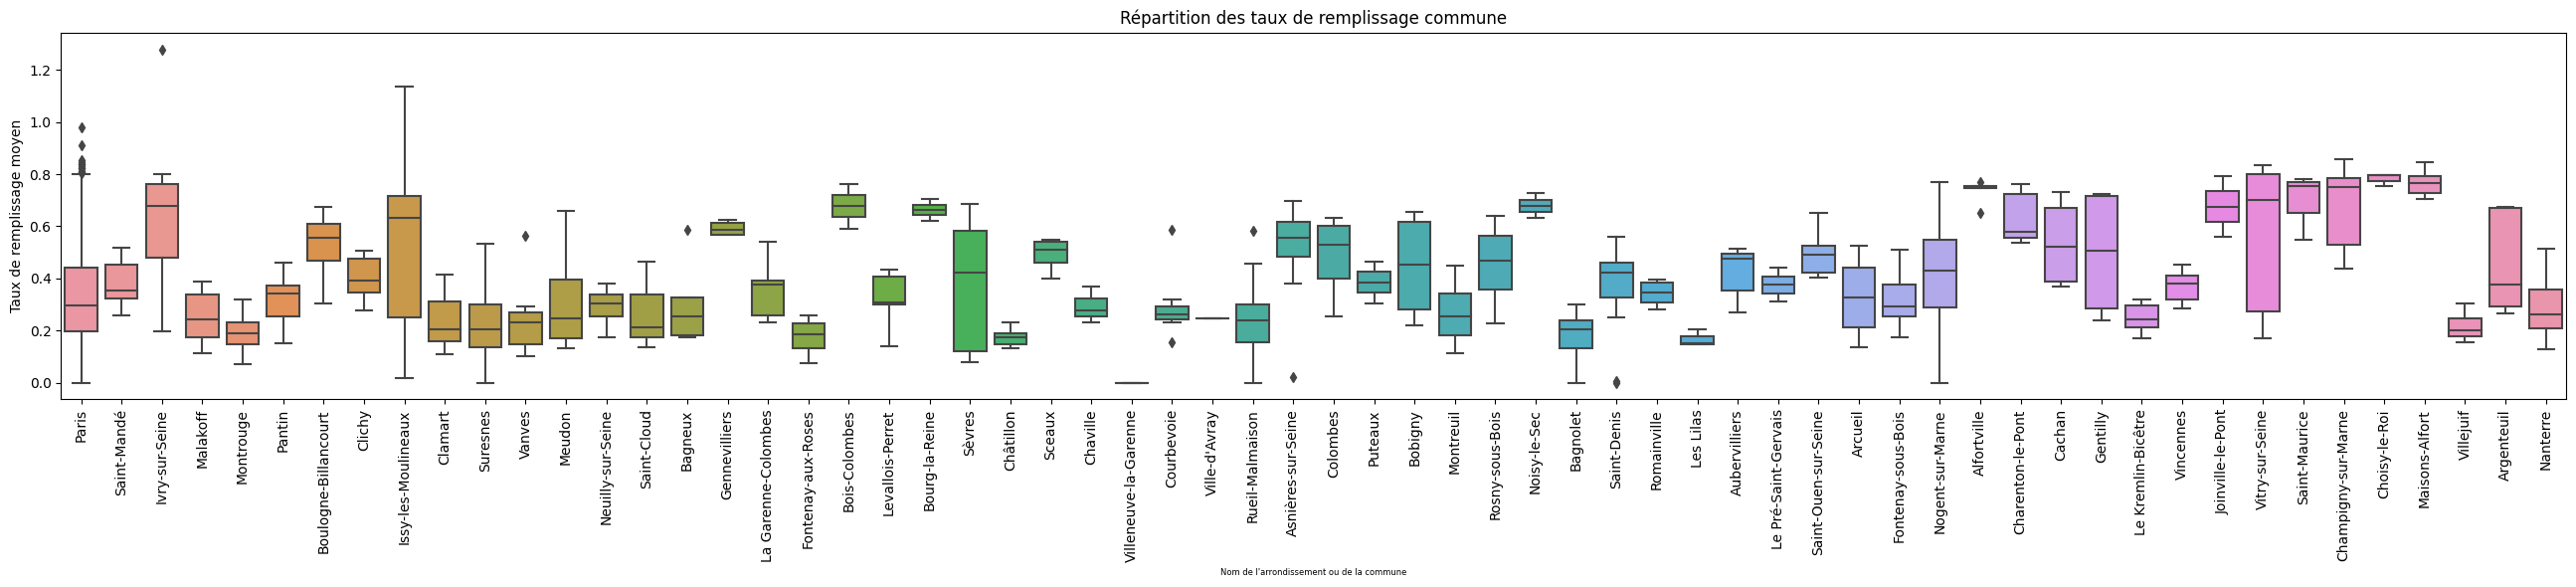

In [64]:
%pip install seaborn

import seaborn as sns
# data colonnes : 	stationcode	name	capacity	coordonnees_geo	nom_arrondissement_communes	remplissage_moyen	docks_disponibles	velos_disponibles	velos_mecaniques_disponibles	velos_electriques_disponibles
data2 = data.copy(deep=True)

# convertir décimal en float
data2['remplissage_moyen'] = data2['remplissage_moyen'].apply(lambda x: float(x))

# Création de la boîte à moustaches
plt.figure(figsize=(26, 6))
sns.boxplot(x='nom_arrondissement_communes', y='remplissage_moyen', data=data2)
plt.xlabel('Nom de l\'arrondissement ou de la commune', fontsize=6 )
plt.ylabel('Taux de remplissage moyen')
plt.title('Répartition des taux de remplissage commune')
plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique de la disposition du graphique
plt.show()

In [68]:
print(data2['remplissage_moyen'].describe())

count    1449.000000
mean        0.357763
std         0.187680
min         0.000000
25%         0.209461
50%         0.319144
75%         0.475408
max         1.278499
Name: remplissage_moyen, dtype: float64


In [67]:
print(data2['capacity'].describe())

count    1449.000000
mean       31.456177
std        11.561673
min        11.000000
25%        23.000000
50%        29.000000
75%        37.000000
max        74.000000
Name: capacity, dtype: float64


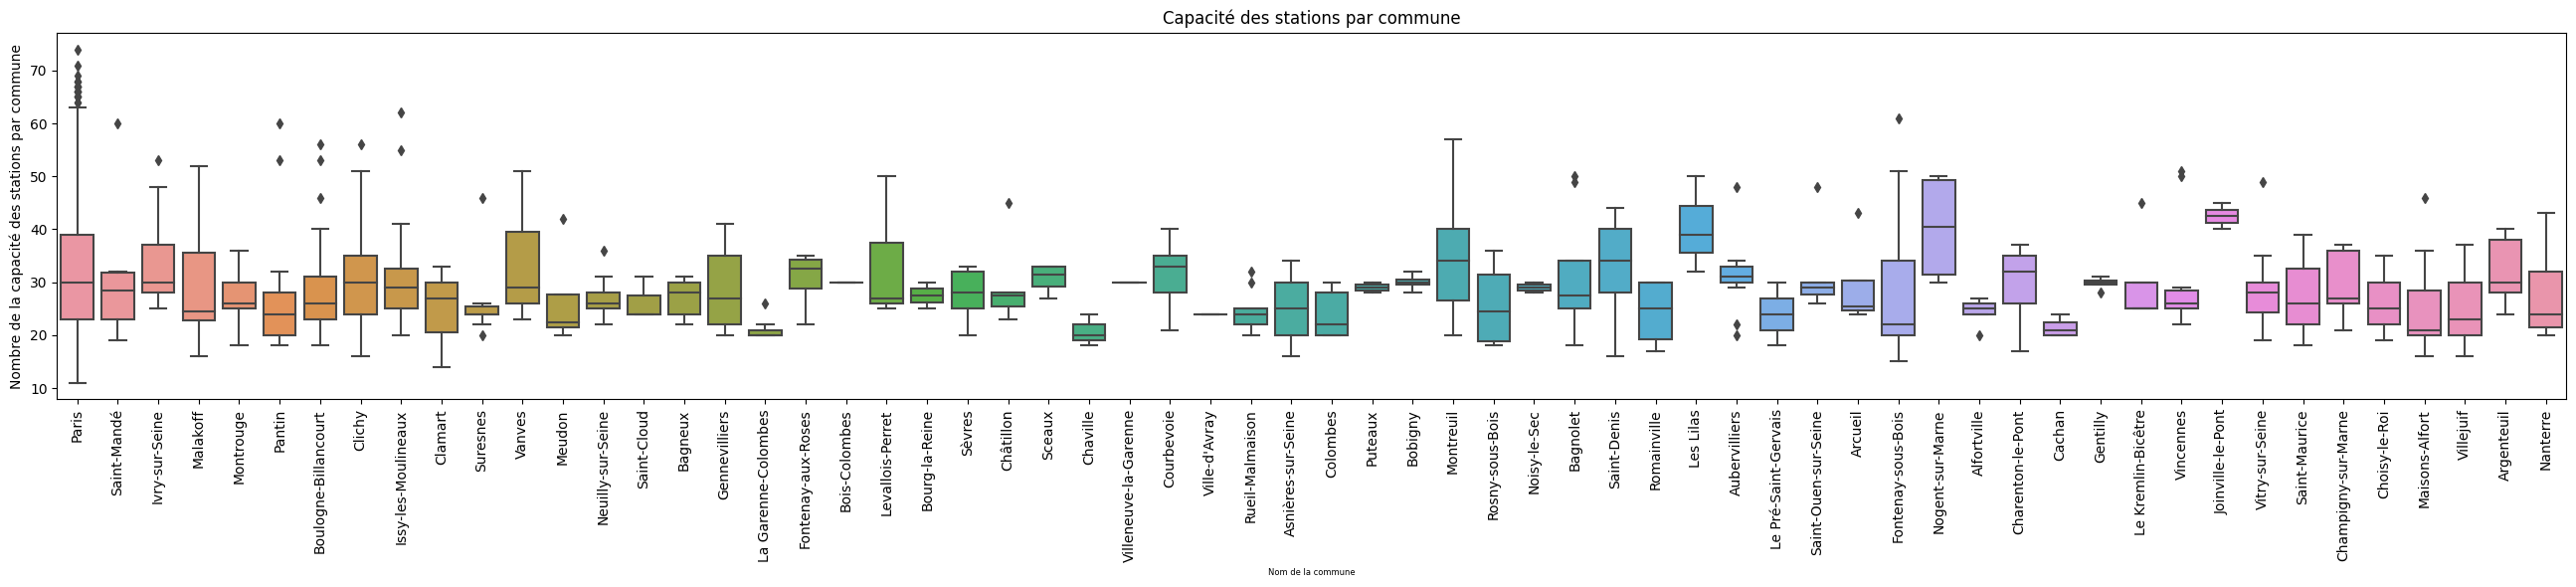

In [60]:
import seaborn as sns
# data colonnes : 	stationcode	name	capacity	coordonnees_geo	nom_arrondissement_communes	remplissage_moyen	docks_disponibles	velos_disponibles	velos_mecaniques_disponibles	velos_electriques_disponibles
data2 = data.copy(deep=True)

# Création de la boîte à moustaches
plt.figure(figsize=(26, 6))
sns.boxplot(x='nom_arrondissement_communes', y='capacity', data=data2)
plt.xlabel('Nom de la commune', fontsize=6 )
plt.ylabel('Nombre de la capacité des stations par commune')
plt.title('Capacité des stations par commune')
plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique de la disposition du graphique
plt.show()

In [69]:
query = """
SELECT
    stationcode,
    SUM(total_movement) AS total_movement,
    nom_arrondissement_communes
FROM
    (
    SELECT
        si.stationcode,
        ABS(COALESCE(ss.ebike - LAG(ss.ebike) OVER (PARTITION BY ss.stationcode ORDER BY ss.date), 0)) AS total_movement,
        si.nom_arrondissement_communes AS nom_arrondissement_communes
    FROM
        station_information AS si
        INNER JOIN station_status AS ss ON si.stationcode = ss.stationcode
    WHERE
        si.capacity > 0
    ) AS subquery
GROUP BY
    stationcode;
"""

stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

dataEbike = pd.DataFrame(stations, columns=cursor.column_names)
display(dataEbike)

,stationcode,name,capacity,coordonnees_geo,nom_arrondissement_communes,remplissage_moyen,docks_disponibles,velos_disponibles,velos_mecaniques_disponibles,velos_electriques_disponibles
0,10001,René Boulanger - Lancry,62,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 141, 164, 147, 91,...",Paris,0.19260050,48.5693,11.9412,8.5308,3.4105
1,10003,Hauteville - Bonne Nouvelle,17,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 172, 9, 218, 27, 2...",Paris,0.32055496,10.5951,5.4494,2.7437,2.7057
2,10004,Metz - Faubourg Saint-Denis,48,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 254, 151, 107, 209...",Paris,0.38353825,27.0979,18.4098,13.8189,4.5910
3,10005,Petites Ecuries - Faubourg Poissonnière,17,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 122, 55, 126, 11, ...",Paris,0.44411018,8.5566,7.5499,4.9377,2.6122
4,10006,Petites Ecuries - Faubourg Saint-Denis,29,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 184, 110,...",Paris,0.37412320,16.4791,10.8496,7.4449,3.4046
...,...,...,...,...,...,...,...,...,...,...
1444,92004,Nanterre - Université,20,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 124, 180, 56, 99, ...",Nanterre,0.30697876,12.9310,6.1396,3.0441,3.0955
1445,92005,Gare de Nanterre Ville,43,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 198, 59, 118, 6, 2...",Nanterre,0.19329549,33.5946,8.3117,4.5987,3.7130
1446,92006,Place Nelson Mandela,30,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 172, 10, ...",Nanterre,0.13050489,25.7446,3.9151,0.9894,2.9258
1447,92007,Pesaro - Préfecture,22,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 117, 144,...",Nanterre,0.22667450,16.4731,4.9868,1.8102,3.1766


In [70]:
query = """
SELECT
    stationcode,
    SUM(total_movement) AS total_movement,
    nom_arrondissement_communes
FROM
    (
    SELECT
        si.stationcode,
        ABS(COALESCE(ss.mechanical - LAG(ss.mechanical) OVER (PARTITION BY ss.stationcode ORDER BY ss.date), 0)) AS total_movement,
        si.nom_arrondissement_communes AS nom_arrondissement_communes
    FROM
        station_information AS si
        INNER JOIN station_status AS ss ON si.stationcode = ss.stationcode
    WHERE
        si.capacity > 0
    ) AS subquery
GROUP BY
    stationcode;
"""

stations = []
with cursorContext(Db.db) as cursor:
    try:
        cursor.execute(query, ())
    except Exception as e:
        print(Fore.RED + "Erreur lors de récupération des données : " + str(e) + Style.RESET_ALL)

    stations = cursor.fetchall()

dataMechanical = pd.DataFrame(stations, columns=cursor.column_names)
display(dataMechanical)

,stationcode,total_movement,nom_arrondissement_communes
0,10001,3394,Paris
1,10003,2801,Paris
2,10004,5204,Paris
3,10005,3055,Paris
4,10006,5635,Paris
...,...,...,...
1444,92004,382,Nanterre
1445,92005,641,Nanterre
1446,92006,274,Nanterre
1447,92007,549,Nanterre


In [74]:
# renommer colonnes ebike et mechanical
dataEbike.rename(columns={'total_movement': 'total_movement_ebike'}, inplace=True)
dataMechanical.rename(columns={'total_movement': 'total_movement_mechanical'}, inplace=True)


dataGrouped = pd.merge(dataEbike, dataMechanical, on=['stationcode', 'nom_arrondissement_communes'], how='inner')
# colonnes : stationcode	total_movement_ebike	nom_arrondissement_communes	total_movement_mechanical

display(dataGrouped)

,stationcode,total_movement_ebike,nom_arrondissement_communes,total_movement_mechanical
0,10001,3475,Paris,3394
1,10003,2881,Paris,2801
2,10004,4407,Paris,5204
3,10005,3030,Paris,3055
4,10006,5053,Paris,5635
...,...,...,...,...
1444,92004,695,Nanterre,382
1445,92005,825,Nanterre,641
1446,92006,671,Nanterre,274
1447,92007,1195,Nanterre,549


,total_movement_ebike,total_movement_mechanical,part_mechanical,part_ebike
nom_arrondissement_communes,,,,
Alfortville,6405,4404,0.4074382459061892867055231751,0.5925617540938107132944768249
Arcueil,8333,3623,0.3030277684844429575108732017,0.6969722315155570424891267983
Argenteuil,1592,671,0.2965090587715422006186478126,0.7034909412284577993813521874
Asnières-sur-Seine,20273,14652,0.4195275590551181102362204724,0.5804724409448818897637795276
Aubervilliers,25639,13159,0.3391669673694520336099798959,0.6608330326305479663900201041
Bagneux,6783,2016,0.2291169451073985680190930788,0.7708830548926014319809069212
Bagnolet,14779,2096,0.1242074074074074074074074074,0.8757925925925925925925925926
Bobigny,3579,1225,0.2549958368026644462947543714,0.7450041631973355537052456286
Bois-Colombes,1940,1059,0.3531177059019673224408136045,0.6468822940980326775591863955


C:\Users\Maxpi\AppData\Local\Temp\ipykernel_33572\1690438373.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dataParCommune.index, rotation=90)


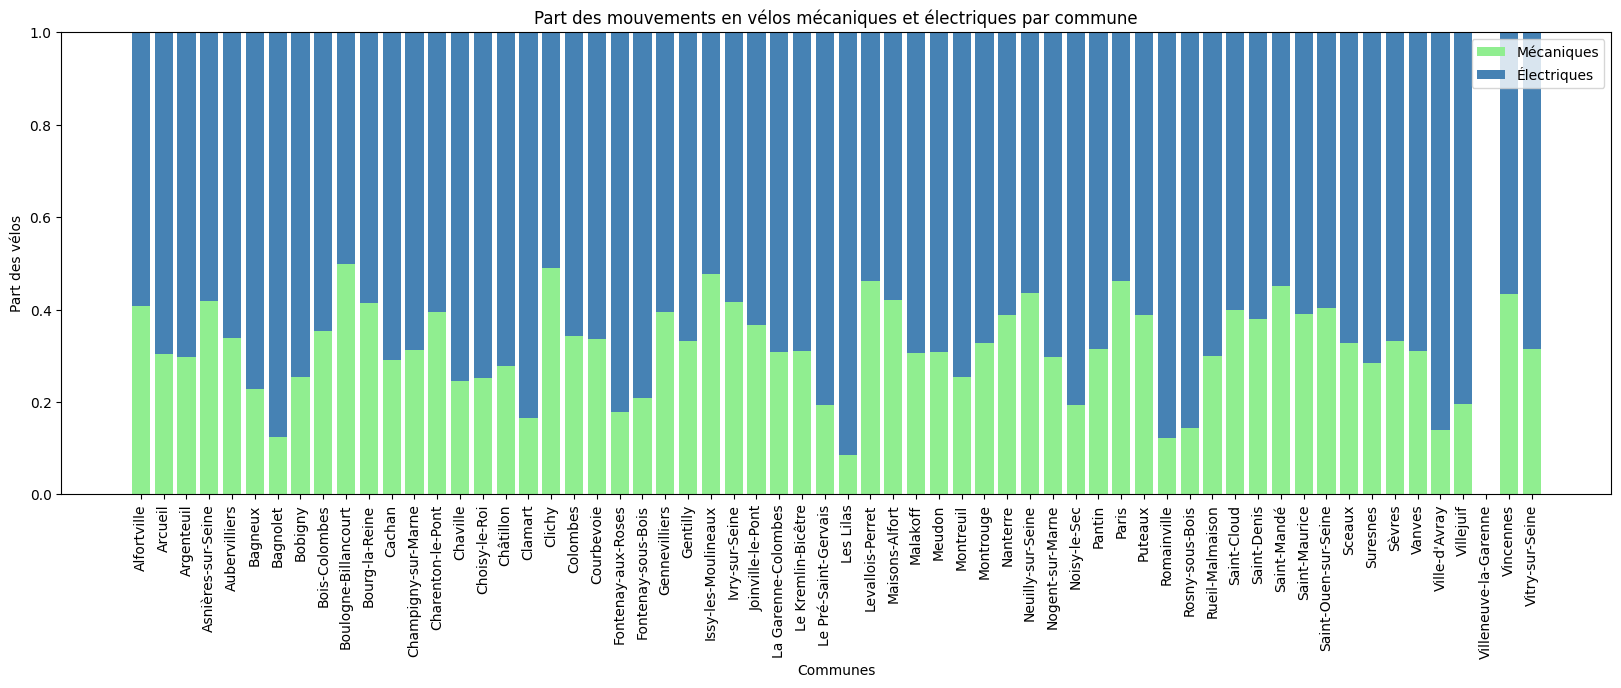

Total mechanical : 2660632
Total ebike : 3352865


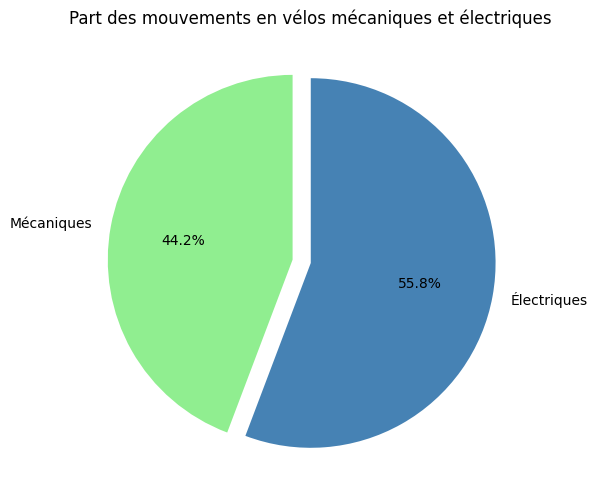

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Groupement par commune et calcul de la somme des mouvements mécaniques et électriques
dataParCommune = dataGrouped.groupby('nom_arrondissement_communes')[['total_movement_ebike', 'total_movement_mechanical']].sum()

# Calcul de la part des vélos mécaniques et électriques par commune
dataParCommune['part_mechanical'] = dataParCommune.apply(lambda row: row['total_movement_mechanical'] / (row['total_movement_ebike'] + row['total_movement_mechanical']) if (row['total_movement_ebike'] + row['total_movement_mechanical']) > 0 else 0, axis=1)
dataParCommune['part_ebike'] = dataParCommune.apply(lambda row: row['total_movement_ebike'] / (row['total_movement_ebike'] + row['total_movement_mechanical']) if (row['total_movement_ebike'] + row['total_movement_mechanical']) > 0 else 0, axis=1)

display(dataParCommune.head(10))

# Création du graphique à barres empilées
fig, ax = plt.subplots(figsize=(20, 6))

# Barres pour la part des vélos mécaniques
ax.bar(dataParCommune.index, dataParCommune['part_mechanical'], label='Mécaniques', color='lightgreen')

# Barres pour la part des vélos électriques, empilées sur les barres mécaniques
ax.bar(dataParCommune.index, dataParCommune['part_ebike'], bottom=dataParCommune['part_mechanical'], label='Électriques',  color='steelblue')

# Personnalisation de l'axe des x
ax.set_xlabel('Communes')
ax.set_xticklabels(dataParCommune.index, rotation=90)
ax.set_xticks(range(len(dataParCommune)))
ax.set_title('Part des mouvements en vélos mécaniques et électriques par commune')

# Personnalisation de l'axe des y
ax.set_ylabel('Part des vélos')
ax.set_ylim(0, 1)  # Assurez-vous que l'axe des y va de 0 à 1 pour représenter les parts

# Légende
ax.legend()

# Affichage du graphique
plt.show()

#piechart qui représente la part des vélos mécaniques et électriques en tout
fig, ax = plt.subplots(figsize=(20, 6))

# Calcul du total des mouvements mécaniques et électriques
total_mechanical = dataParCommune['total_movement_mechanical'].sum()
total_ebike = dataParCommune['total_movement_ebike'].sum()

print("Total mechanical : " + str(total_mechanical))
print("Total ebike : " + str(total_ebike))

# Création des données pour le pie chart
labels = ['Mécaniques', 'Électriques']
sizes = [total_mechanical, total_ebike]
colors = ['lightgreen', 'steelblue']
explode = (0.1, 0)  # Pour mettre en évidence la part mécanique

# Création du pie chart
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Titre du pie chart
ax.set_title('Part des mouvements en vélos mécaniques et électriques')

# Affichage du pie chart
plt.show()


